In [353]:
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

In [364]:
def parse_ts(ts:dict):
    """Given time series data in a dictionary format, return results in a pandas df"""
    return pd.DataFrame.from_dict(ts, orient='index')

def get_local_minmax(rsi, min_max='min'):
    is_loc = []
    data = rsi['RSI'].values

    for i, p in enumerate(data):
        if i in [0, 1, len(data)-1, len(data)-2]:
            ind = 0
        elif min_max == 'min' and p < data[i+1] and p < data[i-1] and p < data[i+2] and p < data[i-2]:
            ind = 1
        elif min_max == 'max' and p > data[i+1] and p > data[i-1] and p > data[i+2] and p > data[i-2]:
            ind = 1
        else:
            ind = 0
        is_loc.append(ind)
    return is_loc


def get_stock_price(key, ticker):
    # Get raw timeseries data
    ts = TimeSeries(key)
    price, meta = ts.get_intraday(symbol=ticker, interval='60min', outputsize='full')
    price = parse_ts(price).reset_index().rename(columns={'index':'ts',
                                                               '4. close':'closing_price'})[['ts','closing_price']]
    price['ts'] = pd.to_datetime(price['ts'])
    price['closing_price'] = price['closing_price'].astype(float)
    return price


def get_rsi(key, ticker):
    # get RSI values
    ti = TechIndicators(key)
    rsi = parse_ts(ti.get_rsi(symbol=ticker, interval='60min')[0]).reset_index().rename(columns={'index':'ts'})
    # format RSI data 
    print(rsi)
    rsi['is_loc_min'] = get_local_minmax(rsi=rsi, min_max='min')
    rsi['is_loc_max'] = get_local_minmax(rsi=rsi, min_max='max')
    rsi['ts'] = pd.to_datetime(rsi['ts'])
    rsi['RSI'] = rsi['RSI'].astype(float)
    rsi['low_value'] = (rsi['RSI'] < 25).astype(int)
    rsi['high_value'] = (rsi['RSI'] > 75).astype(int)
    rsi = rsi.rename(columns={'index':'ts'})
    
    # find buy points
    poss_b = rsi[(rsi.is_loc_min == 1) & (rsi.low_value == 1)].reset_index().rename(columns={'index':'ind'})
    poss_b['ind_delta'] = poss_b.ind.diff()
    poss_b['rsi_delta'] = poss_b.RSI.diff()
    poss_b['buy_point'] = [1 if i <= 10 and r > 0 else 0 for i, r in zip(poss_b['ind_delta'], poss_b['rsi_delta'])] 
    poss_b['buy_point'] = poss_b['buy_point'].fillna(0)
    
    # find sell points
    poss_s = rsi[(rsi.is_loc_max == 1) & (rsi.high_value == 1)].reset_index().rename(columns={'index':'ind'})
    poss_s['ind_delta'] = poss_s.ind.diff()
    poss_s['rsi_delta'] = poss_s.RSI.diff()
    poss_s['sell_point'] = [1 if i <= 10 and r < 0 else 0 for i, r in zip(poss_s['ind_delta'], poss_s['rsi_delta'])] 
    poss_s['sell_point'] = poss_s['sell_point'].fillna(0)
    
    # merge together
    poss = pd.merge(poss_b, poss_s, how='outer',on='ts')
    
    return pd.merge(rsi, poss[['ts','sell_point','buy_point']], how='left', on='ts')


In [365]:
k = 'OQX9VO6JOXSLUBGF'
ticker = 'ZM'

In [366]:
# pull data from API
stock = get_stock_price(key=k, ticker=ticker)
rsi = get_rsi(key=k, ticker=ticker)

Empty DataFrame
Columns: [ts]
Index: []


KeyError: 'RSI'

In [357]:
stock.head()

,ts,closing_price
0,2020-03-20 15:30:00,146.6200
1,2020-03-20 14:30:00,149.4324
2,2020-03-20 13:30:00,148.9885
3,2020-03-20 12:30:00,148.9100
4,2020-03-20 11:30:00,149.2500


In [358]:
rsi.head()

,ts,RSI,is_loc_min,is_loc_max,low_value,high_value,sell_point,buy_point
0,2019-12-30 11:30:00,55.2457,0,0,0,0,NaN,NaN
1,2019-12-30 12:30:00,52.7944,0,0,0,0,NaN,NaN
2,2019-12-30 13:30:00,53.2058,0,0,0,0,NaN,NaN
3,2019-12-30 14:30:00,52.8534,0,0,0,0,NaN,NaN
4,2019-12-30 15:30:00,52.7284,0,0,0,0,NaN,NaN


In [359]:
rsi[rsi.buy_point == 1]

,ts,RSI,is_loc_min,is_loc_max,low_value,high_value,sell_point,buy_point
278,2020-02-27 09:30:00,19.0842,1,0,1,0,NaN,1.0
285,2020-02-28 09:30:00,19.1861,1,0,1,0,NaN,1.0


In [360]:
rsi[rsi.sell_point == 1]

,ts,RSI,is_loc_min,is_loc_max,low_value,high_value,sell_point,buy_point
103,2020-01-22 09:30:00,86.8021,0,1,0,1,1.0,NaN


In [361]:
# merge together
df = pd.merge(stock, rsi, how='inner',on='ts').sort_values('ts').reset_index().drop(columns='index')
df.tail()

,ts,closing_price,RSI,is_loc_min,is_loc_max,low_value,high_value,sell_point,buy_point
392,2020-03-20 11:30:00,149.2500,44.7960,0,0,0,0,NaN,NaN
393,2020-03-20 12:30:00,148.9100,44.5645,1,0,0,0,NaN,NaN
394,2020-03-20 13:30:00,148.9885,44.6341,0,0,0,0,NaN,NaN
395,2020-03-20 14:30:00,149.4324,45.0444,0,0,0,0,NaN,NaN
396,2020-03-20 15:30:00,146.6200,42.9229,0,0,0,0,NaN,NaN


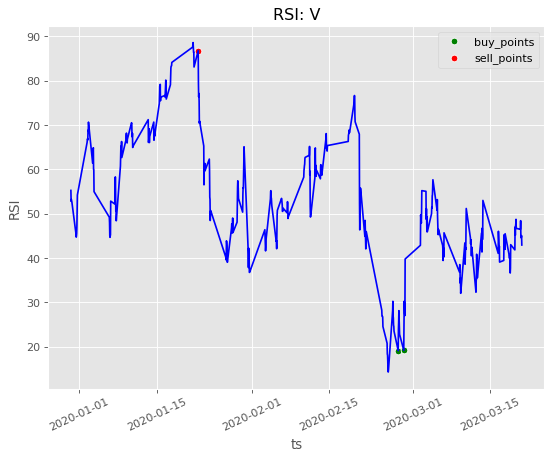

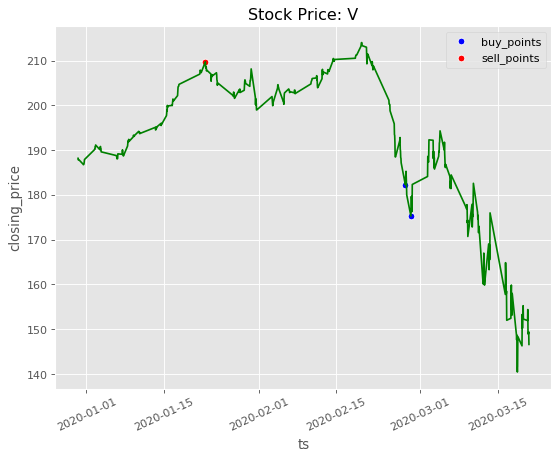

In [345]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

plt.style.use('ggplot')

# plot rsi
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.lineplot(x="ts", y="RSI",
             data=df, color='blue')
sns.scatterplot(x="ts", y="RSI",
             data=df[df.buy_point==1], color = 'green',
               label='buy_points')
sns.scatterplot(x="ts", y="RSI",
             data=df[df.sell_point==1], color = 'red',
               label='sell_points')
plt.xticks(rotation=25)
plt.title(f'RSI: {ticker}')

plt.show()

# plot stock price
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.lineplot(x="ts", y="closing_price", data=df, color='green')
sns.scatterplot(x="ts", y="closing_price", data=df[df.buy_point==1], 
                color = 'blue', label='buy_points')
sns.scatterplot(x="ts", y="closing_price",
             data=df[df.sell_point==1], color = 'red',
               label='sell_points')
plt.xticks(rotation=25)
plt.title(f'Stock Price: {ticker}')

plt.show()

In [346]:
def evaluate(df, time_steps=4, type_='buy'):
    if type_ == 'buy':
        transactions = df[df.buy_point == 1]
    elif type_ == 'sell':
        transactions = df[df.sell_point == 1]
    else:
        print('Enter valid type: (buy, sell)')
        return None
    difs = []
    for i, row in transactions.iterrows():
        purchase_price = row['closing_price']
        later_price = df.iloc[i+time_steps]['closing_price']
        pct_dif = (later_price - purchase_price) / purchase_price
        difs.append(pct_dif)
    avg_dif = np.mean(difs).round(4)*100
    print(str(avg_dif) + '%')
    return avg_dif
    

In [352]:
for t in [1,2,3,4,5,6,7,8,10, 12, 24]:
    print(t)
    evaluate(df=df, time_steps=t, type_='buy')

1
1.03%
2
1.83%
3
1.8599999999999999%
4
0.83%
5
0.29%
6
1.38%
7
0.6%
8
2.45%
10
2.62%
12
2.21%
24
6.2%
